In [479]:
import pandas as pd
import numpy as np
from string import punctuation
import re
from nltk.corpus import stopwords
from collections import Counter 
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from matplotlib import pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import warnings

In [480]:
torch.manual_seed(2023)
torch.cuda.manual_seed(2023)
random.seed(2023)
warnings.filterwarnings("ignore")

## 1. Exploratory Data Analysis and Data Cleaning

In [376]:
df = pd.read_csv('fb_sentiment.csv',index_col=0)
df.head()

,FBPost,Label
0,Drug Runners and a U.S. Senator have somethin...,O
1,"Heres a single, to add, to Kindle. Just read t...",O
2,If you tire of Non-Fiction.. Check out http://...,O
3,Ghost of Round Island is supposedly nonfiction.,O
4,Why is Barnes and Nobles version of the Kindle...,N


In [377]:
print("Dataset has {} posts.".format(df.shape[0]))

Dataset has 1000 posts.


It can be seen that the labels classes are imbalanced, it has to be taken into account while train/test split stage. Moreover, for the imbalanced classes the accuracy metric is not the best mark of the result. 

As far as I understand, the original names of the labels are - 'Positive', 'Negative', 'Other'. Of course, in real life it is worth to understand what the label 'Other' means and whether to include/not to include it in the model. Here due to the small dataset size it is included.

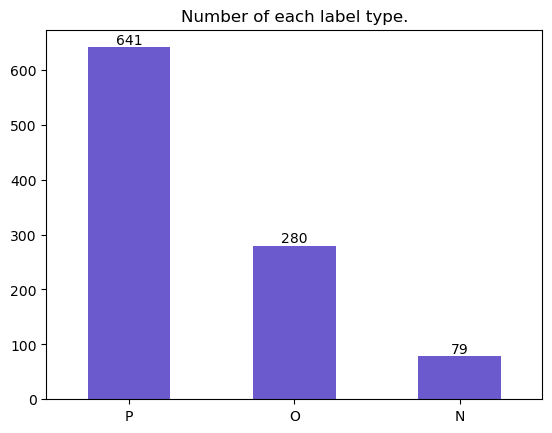

In [378]:
ax = df['Label'].value_counts().plot(kind='bar',color='slateblue',rot=0)
ax.bar_label(ax.containers[0])
plt.title("Number of each label type.")
plt.show()

The process of cleaning is done in accordance with recommendations from the Section 3.1 of Paper ["Social Emotion Mining Techniques
for Facebook Posts Reaction Prediction"](https://arxiv.org/pdf/1712.03249.pdf).

In [379]:
stop_words = stopwords.words('english')

def clean(post):
    """ Cleanes each post from unnecessary symbols."""
    
    post = post.lower()
    post = re.sub('http://\S+|https://\S+', '', post)
    post = re.sub('www.\S+', '', post)
    post = "".join([word for word in post if word not in punctuation])
    post = "".join([word for word in post if word.isalpha() or word==' '])
    post = re.sub(' +', ' ',post)
    post = post.split()
    post = " ".join([word for word in post if word not in stop_words])
    
    return post
    
# Clean the posts
df["FBPost"] =  df["FBPost"].apply(lambda post: clean(post))
df = df[df['FBPost'] != '']
print("After cleaning only {} posts are left.".format(df.shape[0]))

# Encode the labels
df["LabelIdx"] = np.where(df["Label"]=='P',2,np.where(df["Label"]=='O',1,0))

# Create corpus and labels
corpus, labels = list(df['FBPost']), list(df['LabelIdx'])

After cleaning only 991 posts are left.


The sequence length for all the encoded posts has to be chosen carefully and here the length of the original posts can help. As it can be seen, the distribution is not normal, that is why the median metric instead of mean is used. There are practically no posts with lengths larger 45, that is why this sequence length is chosen further on.

Median length of the post:  8.0
Max length of the post:  119
Min length of the post:  1


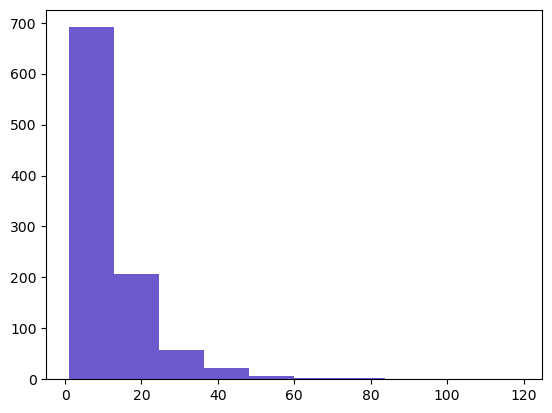

In [451]:
posts_lengths = [len(post.split()) for post in corpus]
print("Median length of the post: ", np.median(posts_lengths))
print("Max length of the post: ", max(posts_lengths))
print("Min length of the post: ", min(posts_lengths))

plt.hist(posts_lengths, bins=10,color='slateblue')
plt.show()

## 2. Feature extraction

In [381]:
def create_vocab(corpus):
    text = " ".join(corpus)
    words = text.split()
    words_count = Counter(words)
    words_num=len(words)
    words_sorted=words_count.most_common(words_num)
    print("Most common words: ", words_sorted[:10],"\n")

    words_idx={w:i+1 for i,(w,c) in enumerate(words_sorted)}
    vocab_size = len(words_idx)
    print("The size of the vocabulary: ", vocab_size)
    
    return words_idx

words_idx = create_vocab(corpus)

Most common words:  [('kindle', 630), ('love', 378), ('books', 186), ('read', 157), ('one', 142), ('book', 125), ('reading', 104), ('would', 92), ('get', 78), ('like', 76)] 

The size of the vocabulary:  2839


In [382]:
def encode_post(post):
    """ Encode the post."""
    
    post_encoded=list()
    for word in post.split():
        if word not in words_idx.keys():
            post_encoded.append(0)
        else:
            post_encoded.append(words_idx[word])
            
    return post_encoded

corpus_encoded = [encode_post(post) for post in corpus]

In [384]:
def pad_post(corpus_encoded, sequence_length=30):
    """ Padding of the post."""
    
    features=np.zeros((len(corpus_encoded), sequence_length), dtype=int)
    for i, post in enumerate(corpus_encoded):
        post_len=len(post)
        if (post_len<=sequence_length):
            zeros=list(np.zeros(sequence_length-post_len))
            new=zeros+post
        else:
            new=post[:sequence_length]
        features[i,:]=np.array(new)
        
    return features

sequence_length=45
features = pad_post(corpus_encoded,sequence_length=sequence_length)

In [385]:
# Create train/validation/test datasets
X_train, X_val, y_train, y_val = train_test_split(features, labels, stratify=labels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5)

train_data=TensorDataset(torch.LongTensor(X_train), torch.LongTensor(y_train))
valid_data=TensorDataset(torch.LongTensor(X_val), torch.LongTensor(y_val))
test_data=TensorDataset(torch.LongTensor(X_test), torch.LongTensor(y_test))

batch_size=50
train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader=DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=True)

## 3. RNN Model train and test

The neural network is the combination of the standard RNN and LSTM approaches. Here the model consists of:
- Embedding layer
- 2 LSTM layers
- Linear layer to produce the 3-dim output.

The data is not that massive and the post sequences are not very long, that is why the model does not need to be heavy. As we will see that strategy is going to work. After 4/5 epochs the model starts loosing in validation metric and overfits, that is why epochs=5 is chosen.

In [402]:
class RnnSent(nn.Module):
    """The RNN model for Sentiment analysis."""
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        super().__init__()
        self.output_size=output_size
        self.n_layers=n_layers
        self.hidden_dim=hidden_dim
        
        # Layers
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.lstm=nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.fc1=nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, h):
        """Perform forward pass."""

        embed=self.embedding(x)
        lstm_out, (ht, ct) = self.lstm(embed, h)    
        out=self.fc1(ht[-1])

        return out, (ht, ct)
    
    def init_hidden(self, batch_size):
        """Initialize Hidden State"""
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [403]:
# Parameters for neural network
vocab_size = len(words_idx)+1
output_size = 3 # Corresponds to number of classes
embedding_dim = 400 # Embedding dimension for each word
hidden_dim = 64
n_layers = 2 # Number of LSTM units

net = RnnSent(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

RnnSent(
  (embedding): Embedding(2840, 400)
  (lstm): LSTM(400, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=64, out_features=3, bias=True)
)


### Train the model

Epoch: 1... Train mean cross-entropy loss: 0.992... Validation mean cross-entropy loss: 0.864
Epoch: 2... Train mean cross-entropy loss: 0.786... Validation mean cross-entropy loss: 0.796
Epoch: 3... Train mean cross-entropy loss: 0.662... Validation mean cross-entropy loss: 0.701
Epoch: 4... Train mean cross-entropy loss: 0.494... Validation mean cross-entropy loss: 0.679
Epoch: 5... Train mean cross-entropy loss: 0.352... Validation mean cross-entropy loss: 0.590


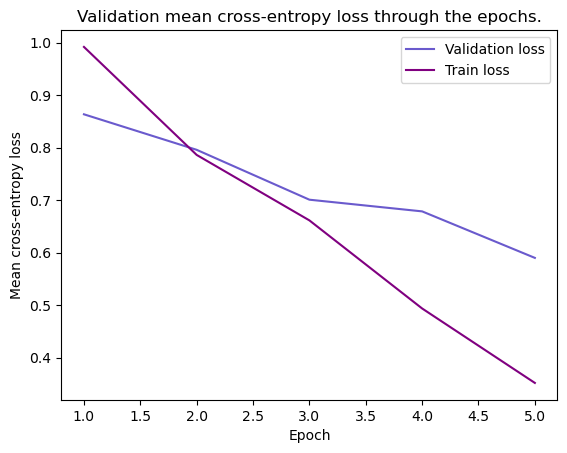

In [404]:
# Check availability of CUDA
train_on_gpu = torch.cuda.is_available()
train_on_gp = False
if(train_on_gpu):
    net.cuda()

# Training parameters
lr = 0.001
epochs = 5 # Larger number of epochs has been tested, but it leads to overfitting
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train the net
net.train()
val_losses_means, train_losses_means = [], []

for e in range(epochs):
    train_losses = []
    
    # Loop through train batches
    for inputs, labels in train_loader:
        batch_size_current = inputs.shape[0]
        h = net.init_hidden(batch_size_current)

        if(train_on_gpu):
            inputs=inputs.cuda()
            labels=labels.cuda()

        optimizer.zero_grad()
        
        output, _ = net(inputs, h)
        loss = criterion(output.squeeze(), labels)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Validation
    net.eval()
    val_losses = []
    
    for inputs, labels in valid_loader:
        batch_size_current = inputs.shape[0]
        val_h = net.init_hidden(batch_size_current)

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()  
            
        output, _ = net(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels)
        val_losses.append(val_loss.item())
        
    val_losses_means.append(np.mean(val_losses))
    train_losses_means.append(np.mean(train_losses))

    print("Epoch: {}...".format(e+1),
          "Train mean cross-entropy loss: {:.3f}...".format(np.mean(train_losses)),
          "Validation mean cross-entropy loss: {:.3f}".format(np.mean(val_losses)))
    
    net.train()
    
plt.plot(np.array(range(epochs))+1, val_losses_means, color='slateblue', label = "Validation loss")
plt.plot(np.array(range(epochs))+1, train_losses_means, color='purple', label = "Train loss")
plt.title("Validation mean cross-entropy loss through the epochs.")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean cross-entropy loss")
plt.show()

In [405]:
torch.save(net, "model_lstm.pt")

### Test the model

In [486]:
test_losses = []
test_correct_num = []

# Initialize table to save metrics
labels_classes_metrics = np.zeros((3,6))
values, counts = np.unique(y_test, return_counts=True)
for v, c in zip(values, counts):
    labels_classes_metrics[v,0] = c

# init hidden state
net.eval()

for inputs, labels_true in test_loader:
    h = net.init_hidden(batch_size)

    if(train_on_gpu):
        inputs, labels_true = inputs.cuda(), labels_true.cuda()


    output, _ = net(inputs, h)
    test_loss = criterion(output.squeeze(), labels_true)
    test_losses.append(test_loss.item())

    softmax = nn.Softmax(dim=1)
    pred = softmax(output)
    pred = torch.argmax(pred, dim=1)
    correct_tensor = pred.eq(labels_true.view_as(pred)).numpy()
    test_correct_num.append(np.sum(correct_tensor))
    
    # Add statistics to the table
    values, counts = pred.unique(return_counts=True)
    for v, c in zip(values, counts):
        labels_classes_metrics[v,1] += c
    conf_mat = confusion_matrix(pred, labels_true, labels=[0,1,2])
    for i in range(conf_mat.shape[1]):
        labels_classes_metrics[i,2]+= conf_mat[i,i]
    

test_accuracy_mean = sum(test_correct_num)/len(test_loader.dataset)
test_loss_mean = np.mean(test_losses)
print("Test mean cross-entropy loss: {:.3f}".format(np.mean(test_loss_mean)))
print("Test accuracy: {:.3f} \n".format(test_accuracy_mean))

labels_classes_metrics[:,3] = np.round(labels_classes_metrics[:,2]/labels_classes_metrics[:,1],2)
labels_classes_metrics[:,4] = np.round(labels_classes_metrics[:,2]/labels_classes_metrics[:,0],2)
labels_classes_metrics[:,5] = np.round(2*labels_classes_metrics[:,4]*labels_classes_metrics[:,3]/(labels_classes_metrics[:,4]+labels_classes_metrics[:,3]),2)
metrics_stats = pd.DataFrame(labels_classes_metrics, columns=['Actual class count', 'Predicted class count', 'TP', 'Precision','Recall','F1'], index=['Class 0', 'Class 1', 'Class 2'])
print(metrics_stats)

labels_classes_metrics = np.nan_to_num(labels_classes_metrics)
F1_weighted = (labels_classes_metrics[0,0]*labels_classes_metrics[0,5] + labels_classes_metrics[1,0]*labels_classes_metrics[1,5] + labels_classes_metrics[2,0]*labels_classes_metrics[2,5])/(labels_classes_metrics[0,0]+labels_classes_metrics[1,0]+labels_classes_metrics[2,0])
print("Weighted F1-score is {}.".format(F1_weighted))

Test mean cross-entropy loss: 0.449
Test accuracy: 0.840 

         Actual class count  Predicted class count    TP  Precision  Recall  \
Class 0                 8.0                    1.0   0.0       0.00    0.00   
Class 1                28.0                   33.0  25.0       0.76    0.89   
Class 2                64.0                   66.0  59.0       0.89    0.92   

           F1  
Class 0   NaN  
Class 1  0.82  
Class 2  0.90  
Weighted F1-score is 0.8056.


The table above summarizes the test statistics. Precision, recall, F1 metrics are calculated separately for each class and the weighted F1-score is found. 

It can be observed that for the class 'N' (which had small number of samples), the probelm with prediction exists. Even though stratification was used to divide the data into train/validation/test in accordance with imbalance - the predictions for the concrete class are not accurate. However, for the two other label classes 'O' and 'P' the results are pretty good, the F1-score is high, telling that the learning process gone well.

### Make single prediction with the model

In [487]:
def label_predict(post_original, sequence_length=30):
        post = clean(post_original)
        post = encode_post(post)
        corpus_encoded = [post]
        features = pad_post(corpus_encoded,sequence_length=sequence_length)
        features = torch.from_numpy(features)
        
        if(train_on_gpu):
            features=features.cuda()
            
        batch_size = 1
        h = net.init_hidden(batch_size)
        output, _ = net(features, h)
        softmax = nn.Softmax(dim=1)
        pred = softmax(output)
        lbl = torch.argmax(pred, dim=1).item()

        print("The predicted class for the text '{}' is {} with probability {:.3f}.".format(post_original, lbls[lbl], pred.max()))

In [488]:
lbls = {2:'P',1:'O',0:'N'}
post1 = 'The book is very interesting, I love it very much.'
post2 = 'The app is pretty nice, however, the problem is that it is hard to write sentences there.'
label_predict(post1, sequence_length=sequence_length)
label_predict(post2, sequence_length=sequence_length)

The predicted class for the text 'The book is very interesting, I love it very much.' is P with probability 0.988.
The predicted class for the text 'The app is pretty nice, however, the problem is that it is hard to write sentences there.' is O with probability 0.549.
